# Energy training visualization

In [1]:
import argparse

import torch
import numpy as np
import matplotlib.pyplot as plt

from scripts.energy.classic import Experiment
from src.litmodules import LitClassicModule
from src.utils import flatten_batches, plot_range, predict, plot_particules_prediction

# Set manual seeds
torch.manual_seed(1)
np.random.seed(1)

# Matplotlib defaults
plt.rcParams.update({
    "font.size": 25,
    "figure.figsize": (14, 7),
    "axes.grid": True,
    "grid.color": "#93a1a1",
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Reload python packages when changed
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
args = argparse.Namespace(
    dataset_path="datasets/energydata_complete.csv",
    load_path="checkpoints/energy_smcm/last.ckpt",
    T=24*6,
    batch_size=3,
    num_workers=4,
    epochs=3,
    gpus=1
)
Experiment.exp_name = "energy_visu"
exp = Experiment(args)
exp.datamodule.setup()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Visualize dataset

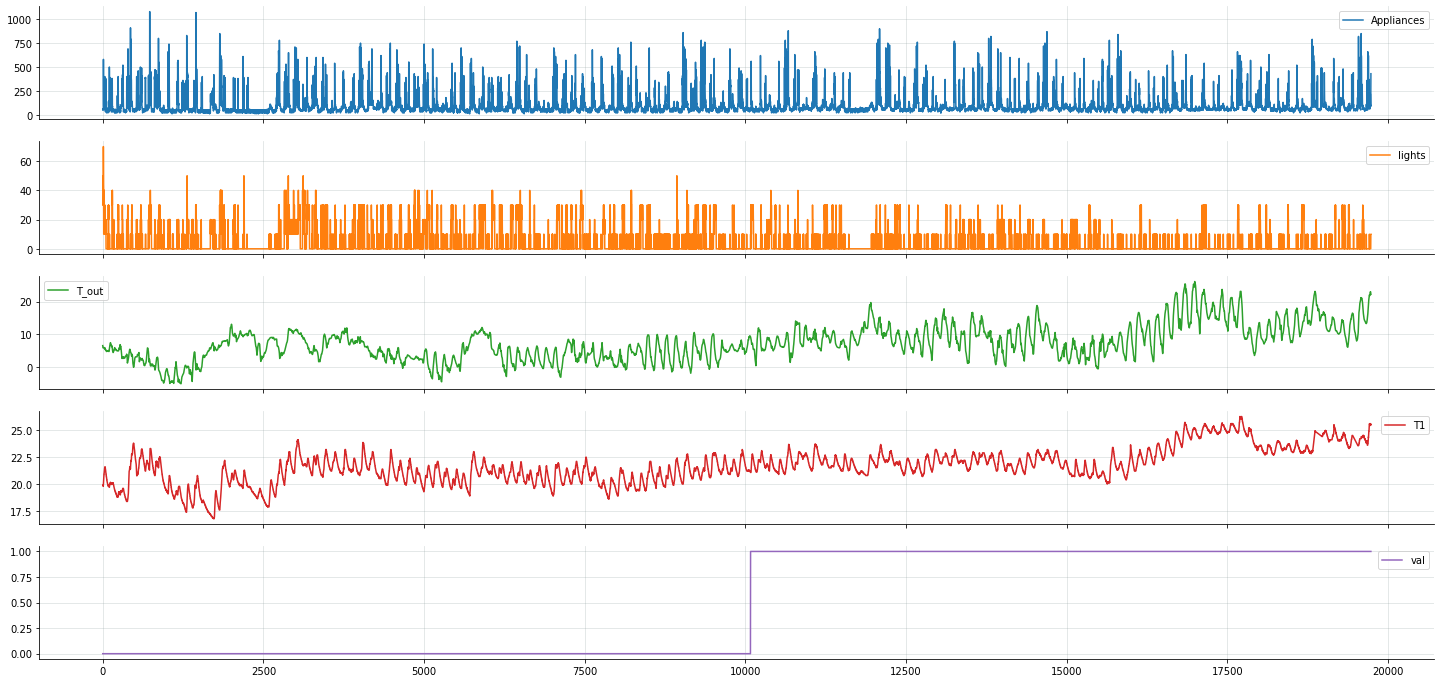

In [3]:
exp.datamodule.visualize()

## Classic evaluations

### Plot the entire dataset

In [4]:
class LitEvalModule(LitClassicModule):
    def validation_step(self, batch, batch_idx):
        u, y = batch
        y_hat = self.model(u)
        loss = self.criteria(y, y_hat)
        return y, y_hat
    def validation_epoch_end(self, outputs):
        observations, predictions = map(flatten_batches, zip(*outputs))
        plt.plot(observations[:, 0].cpu().numpy(), label="observations")
        plt.plot(predictions[:, 0].cpu().numpy(), label="predictions")

eval_module = LitEvalModule.load_from_checkpoint(args.load_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

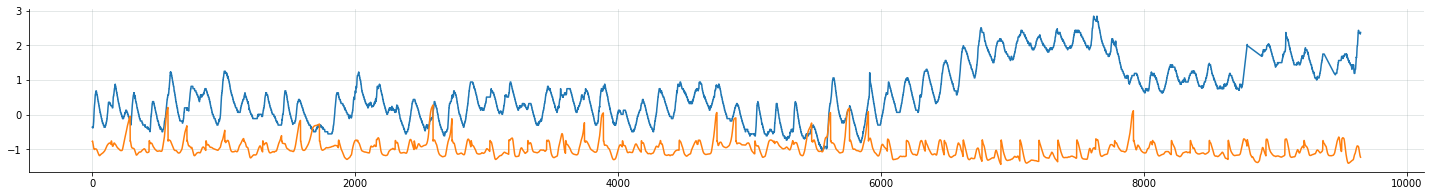

In [5]:
plt.figure(figsize=(25, 3))
exp.trainer.validate(model=eval_module, dataloaders=exp.datamodule.val_dataloader());

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mrmojo/Code/these/SMCL/.env/lib64/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:487: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

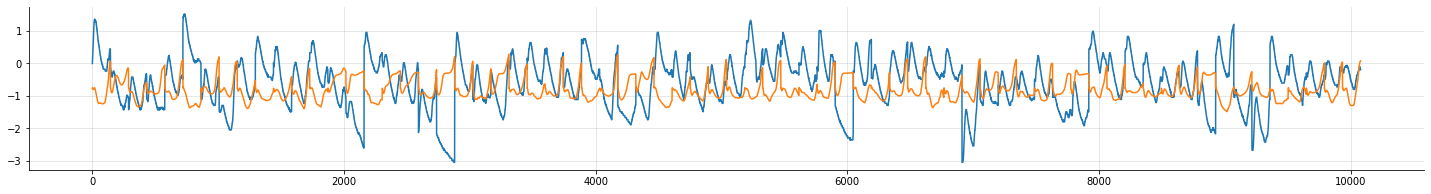

In [6]:
plt.figure(figsize=(25, 3))
exp.trainer.validate(model=eval_module, dataloaders=exp.datamodule.train_dataloader());

### Compute aggregated metrics

In [7]:
class LitMetricsModule(LitClassicModule):
    def validation_step(self, batch, batch_idx):
        u, y = batch
        y_hat = self.model(u)
        mse = torch.nn.functional.mse_loss(y, y_hat, reduction='none')
        mae = torch.nn.functional.l1_loss(y, y_hat, reduction='none')
        return mse, mae
    def validation_epoch_end(self, outputs):
        mse, mae = map(lambda batches: torch.cat(batches, dim=1), zip(*outputs))
        metrics = {
            "mse": self._compute_cumsum(mse),
            "mae": self._compute_cumsum(mae)
        }
        for idx_plot, (metric_name, metric_values) in enumerate(metrics.items()):
            # plt.subplot(len(metrics), 1, idx_plot+1)
            plt.plot(metric_values.squeeze().cpu().numpy(), label=metric_name)
            plt.legend()
    @staticmethod
    def _compute_cumsum(metric):
        return metric.cumsum(dim=0).mean(dim=1) / torch.arange(1, len(metric)+1, device=metric.device).unsqueeze(-1)
    
eval_module = LitMetricsModule.load_from_checkpoint(args.load_path)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

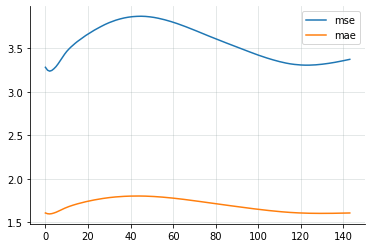

In [8]:
exp.trainer.validate(model=eval_module, dataloaders=exp.datamodule.val_dataloader());

### Evaluate on a validation sample

In [9]:
# Load model
model = exp.litmodule.model

# Load batch
dataloader = exp.datamodule.val_dataloader()
batch_idx = 0
sample_idx = 0
for idx, (commands, observations) in enumerate(dataloader):
    if idx >= batch_idx:
        break

# Compute predictions
with torch.no_grad():
    predictions = model(commands)

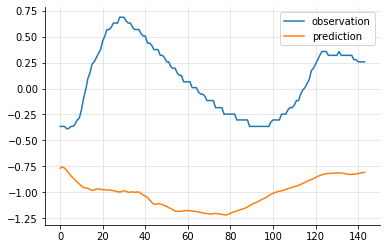

In [10]:
# Plot
plt.plot(observations[:, sample_idx].squeeze().cpu().numpy(), label="observation")
plt.plot(predictions[:, sample_idx].squeeze().cpu().numpy(), label="prediction")
plt.legend()
plt.show()

## Uncertainty evaluations

### Smooth

In [11]:
with torch.no_grad():
    netout = model(commands, observations)

netout = model.smcl.smooth_pms(netout, model.smcl.I).numpy()

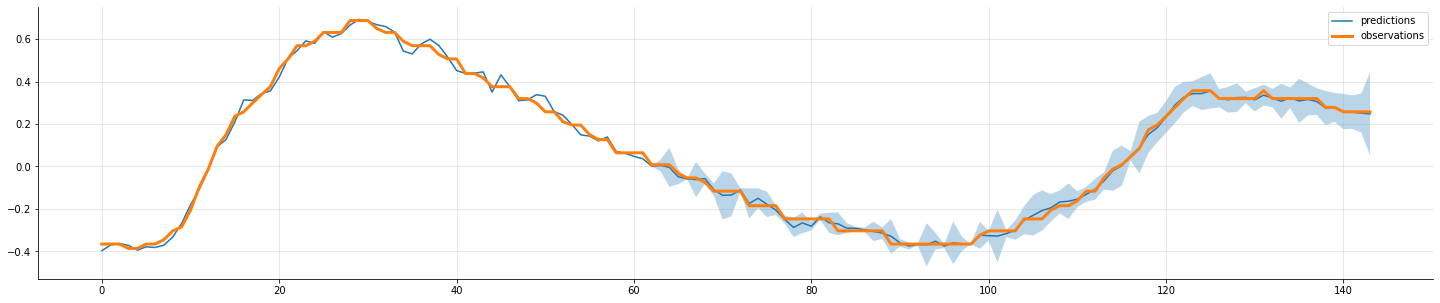

In [12]:
plt.figure(figsize=(25, 5))
plot_range(netout[:, sample_idx, :, 0], label='predictions')
plt.plot(observations[:, sample_idx, 0], lw=3, label='observations')
plt.legend()
plt.show()

### Predict at $t+1$

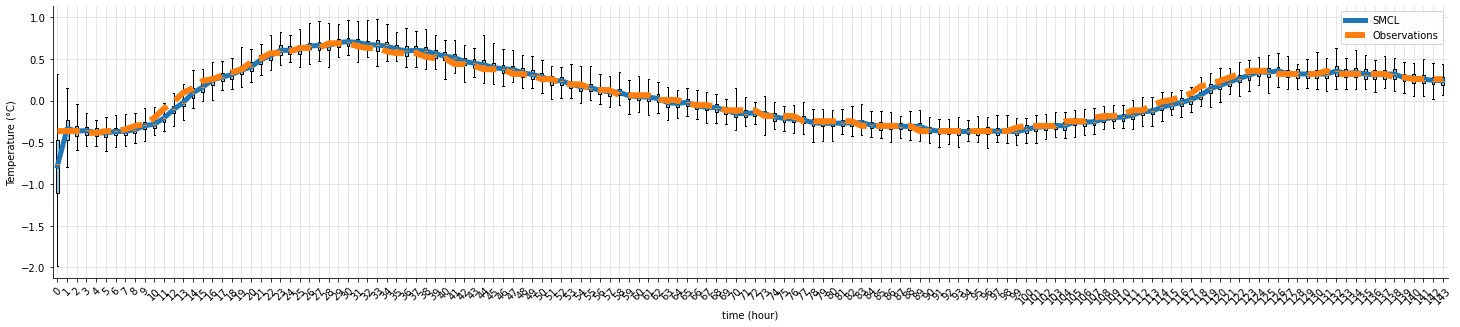

In [13]:
plt.figure(figsize=(25, 5))
predictions = predict(model, commands, observations)
plot_particules_prediction(observations, predictions)

### Predict after the first hour

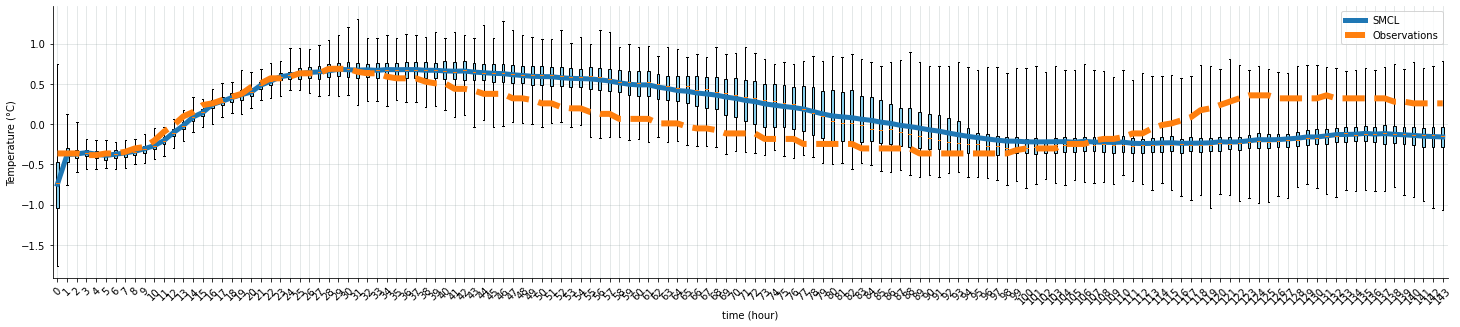

In [14]:
plt.figure(figsize=(25, 5))
predictions = predict(model, commands, observations, hide_start=24)
plot_particules_prediction(observations, predictions)